# One-Zone Model Degeneracies

Looking for degeneracies between Ia DTD and other parameters in the one-zone model outputs.

Preamble

In [108]:
from pathlib import Path
import math as m
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
import vice

# VICE yields
from vice.yields.presets import JW20
vice.yields.ccsne.settings['fe'] = 0.0012 * 10**0.07

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
})

# Plot styles
COLORS = {
    'powerlaw': 'black',
    'powerlaw_broken': 'orange',
    'exponential': 'green',
    'exponential_short': 'blue',
    'bimodal': 'red'
}
LINESTYLES = {
    'insideout': '-',
    'lateburst': '--',
    'exponential': ':',
    'constant': '-.',
}

# Simulation time
TMAX = 13.2 # Gyr
DT = 0.005 # Gyr
simtime = np.arange(0, TMAX+DT, DT) # Gyr

# Stellar mass of Milky Way (Licquia & Newman 2015, ApJ, 806, 96)
M_STAR_MW = 5.17e10

# Default parameters
params = dict(
    elements=('fe', 'o', 'mg'),
    delay=0.04,
    mode='sfr',
    dt=DT,
    eta=2.15,
)

Define star formation histories

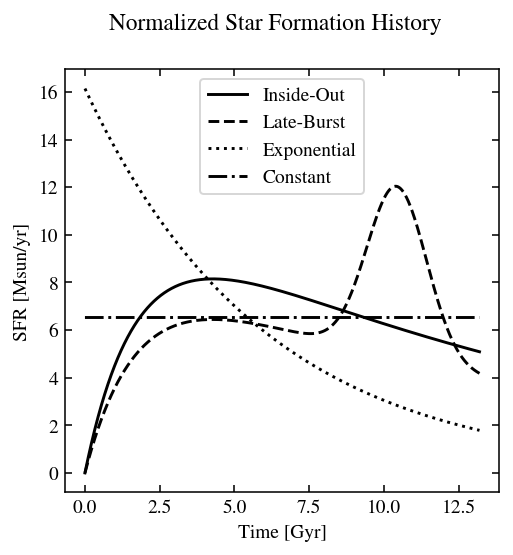

In [109]:
# Star formation history functions
def f_c(t):
    """
    Constant star formation history as a function of time.
    """
    return 1

def f_io(t, tau_rise=2, tau_sfh=15):
    """
    Inside-out star formation history as a function of time.
    t : time in Gyr
    tau_rise : rise timescale in Gyr
    tau_sfh : star formation history timescale in Gyr
    """
    return (1 - m.exp(-t/tau_rise)) * m.exp(-t/tau_sfh)

def f_lb(t, Ab=1.5, tb=10.5, sigma_b=1, **kwargs):
    """
    Inside-out star formation history modified to include a late burst.
    t : time in Gyr
    Ab : dimensionless strength of starburst
    tb : time of local maximum in SFH during burst in Gyr
    sigma_b : width of Gaussian describing burst in Gyr
    """
    burst = Ab * m.exp(-(t-tb)**2/(2*sigma_b**2))
    return f_io(t, **kwargs) * (1 + burst)

def f_exp(t, tau_sfh=6):
    """
    Exponentially declining star formation rate.
    t : time in Gyr
    tau_sfh : exponential timescale in Gyr
    """
    sfr = 1/tau_sfh * m.exp(-t/tau_sfh)
    return sfr

def f_lexp(t, tau_sfh=6):
    """
    Linear-exponential star formation rate.
    This is close enough to inside-out that I don't plan to use it for now.
    t : time in Gyr
    tau_sfh : exponential timescale in Gyr
    """
    sfr = t/tau_sfh * m.exp(-t/tau_sfh)
    return sfr

def normalize(func, dt=DT, recycling=0.4, tmax=TMAX, Mstar=M_STAR_MW):
    """
    Compute normalization pre-factor for star formation function.
    """
    time_integral = sum([func(i * dt) * dt * 1e9 for i in range(int(tmax / dt))])

    return Mstar / ((1 - recycling) * time_integral)

A_c = normalize(f_c)
A_io = normalize(f_io)
A_lb = normalize(f_lb)
A_exp = normalize(f_exp)
A_lexp = normalize(f_lexp)

def const_sfh(t):
    return A_c * f_c(t)

def insideout(t):
    return A_io * f_io(t)

def lateburst(t):
    return A_lb * f_lb(t)

def exp_sfh(t):
    return A_exp * f_exp(t)

def linexp(t):
    return A_lexp * f_lexp(t)

fig, ax = plt.subplots()
ax.plot(simtime, [insideout(t) for t in simtime], c='k', ls=LINESTYLES['insideout'], label='Inside-Out')
ax.plot(simtime, [lateburst(t) for t in simtime], c='k', ls=LINESTYLES['lateburst'], label='Late-Burst')
ax.plot(simtime, [exp_sfh(t) for t in simtime], c='k', ls=LINESTYLES['exponential'], label='Exponential')
# ax.plot(simtime, [linexp(t) for t in simtime], c='k', ls=LINESTYLES['exponential'], label='Linear-Exponential')
ax.plot(simtime, [const_sfh(t) for t in simtime], c='k', ls=LINESTYLES['constant'], label='Constant')
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('SFR [Msun/yr]')
ax.legend()
fig.suptitle('Normalized Star Formation History')
plt.show()

Define SN Ia delay-time distributions

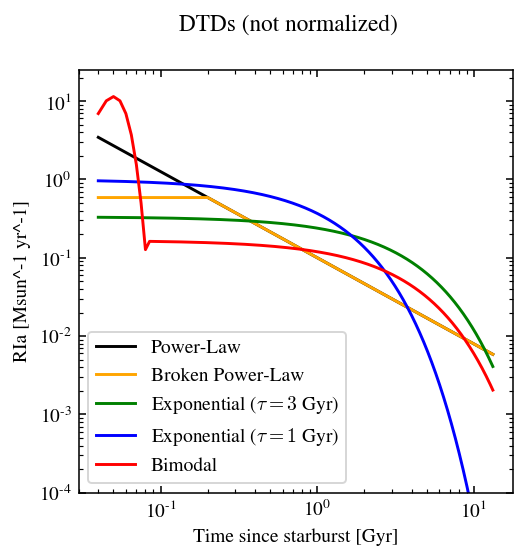

In [111]:
# Delay time distributions
class Exponential:
    """
    The exponential delay-time distribution of SNe Ia.

    Parameters
    ----------
    timescale : float [default: 3]
        The e-folding timescale in Gyr of the exponential.
    norm : float [default: 1]
        The normalization of the exponential, i.e., the value at t=0.
    
    """
    def __init__(self, timescale=3, norm=1):
        self.timescale = timescale
        self.norm = norm

    def __call__(self, time):
        return self.norm * 1/self.timescale * m.exp(-time/self.timescale)


class Powerlaw:
    """
    The power-law delay-time distribution of SNe Ia.

    Parameters
    ----------
    slope : float [default: -1.1]
        The slope of the power law.
    norm : float [default: 1]
        The normalization of the power law, i.e., the value at t=1.
        
    """
    def __init__(self, slope=-1.1, norm=1):
        self.slope = slope
        self.norm = norm

    def __call__(self, time):
        return self.norm * time ** self.slope


class BrokenPowerlaw(Powerlaw):
    """
    A two-part broken power-law delay-time distribution of SNe Ia.
    
    Parameters
    ----------
    tsplit : float [default: 0.2]
        Time in Gyr separating the two power-law components.
    slope1 : float [default: 0]
        Slope of the early power-law component.
    slope2 : float [default: -1.1]
        Slope of the late power-law component.
    norm : float [default: 1]
        Normalization of the second power-law component.
    
    """
    def __init__(self, tsplit=0.2, slope1=0, slope2=-1.1, norm=1):
        self.tsplit = tsplit
        self.plaw2 = Powerlaw(slope=slope2, norm=norm)
        norm1 = norm * tsplit ** (slope2 - slope1)
        self.plaw1 = Powerlaw(slope=slope1, norm=norm1)
    
    def __call__(self, time):
        if time > self.tsplit:
            return self.plaw2(time)
        else:
            return self.plaw1(time)


class Gaussian:
    """
    A Gaussian distribution in time.

    Parameters
    ----------
    center : float [default: 1]
        The location of the peak of the Gaussian function.
    stdev : float [default: 1]
        The standard deviation of the Gaussian function.
    norm : float [default: 1]
        The normalization of the Gaussian function, i.e., the value of the peak.
        
    """
    def __init__(self, center=1, stdev=1, norm=1):
        self.center = center
        self.stdev = stdev
        self.norm = norm

    def __call__(self, time):
        return self.norm * m.exp(-(time-self.center)**2 / (2*self.stdev**2))


class Bimodal(Gaussian, Exponential):
    """
    The bimodal delay-time distribution of SNe Ia. This assumes 50% of SNe Ia
    belong to a prompt component with the form of a narrow Gaussian, and the
    remaining 50% form an exponential DTD.

    Parameters
    ----------
    tsplit : float [default: 0.09]
        Time in Gyr separating the prompt component of SNe Ia from the tardy component.
    prompt : float [default: 0.5]
        Fraction of SNe Ia in the prompt component.
    center : float [default: 0.05]
        Center of the prompt Gaussian component in Gyr.
    stdev : float [default: 0.01]
        Spread of the prompt Gaussian component in Gyr.
    timescale : float [default: 3]
        Timescale of the tardy exponential in Gyr.
    delay : float [default: 0.04]
        Minimum delay time in Gyr.
    tmax : float [default: 13.2]
        Maximum simulation time in Gyr.
        
    """
    def __init__(self, tsplit=0.08, prompt=0.5, center=0.05, stdev=0.01, timescale=3, delay=0.04, tmax=TMAX):
        self.tsplit = tsplit
        Gaussian.__init__(self, center=center, stdev=stdev)
        Exponential.__init__(self, timescale=timescale)
        # Set relative scale of components
        niter = 1000
        gauss_sum = sum([Gaussian.__call__(self, (tsplit-delay)/niter * t + delay) \
                 * tsplit/niter for t in range(niter)])
        exp_sum = sum([Exponential.__call__(self, (tmax-tsplit)/niter * t + tsplit) \
                 * (tmax-tsplit)/niter for t in range(niter)])
        self.scale_gaussian = (exp_sum * prompt) / (gauss_sum * (1 - prompt))

    def __call__(self, time):
        if time < self.tsplit:
            return self.scale_gaussian * Gaussian.__call__(self, time)
        else:
            return Exponential.__call__(self, time)


plaw_dtd = Powerlaw()
broken_dtd = BrokenPowerlaw()
exp_dtd = Exponential()
exp_dtd_short = Exponential(timescale=1)
bi_dtd = Bimodal()

fig, ax = plt.subplots()
tarr = np.arange(0.04, TMAX+DT, DT) # Gyr
ax.plot(tarr, [0.1 * plaw_dtd(t) for t in tarr], c=COLORS['powerlaw'], label='Power-Law')
ax.plot(tarr, [0.1 * broken_dtd(t) for t in tarr], c=COLORS['powerlaw_broken'], label='Broken Power-Law')
ax.plot(tarr, [exp_dtd(t) for t in tarr], c=COLORS['exponential'], label='Exponential ($\\tau=3$ Gyr)')
ax.plot(tarr, [exp_dtd_short(t) for t in tarr], c=COLORS['exponential_short'], label='Exponential ($\\tau=1$ Gyr)')
ax.plot(tarr, [0.5 * bi_dtd(t) for t in tarr], c=COLORS['bimodal'], label='Bimodal')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time since starburst [Gyr]')
ax.set_ylabel('RIa [Msun^-1 yr^-1]')
ax.set_ylim((1e-4, None))
ax.legend()
fig.suptitle('DTDs (not normalized)')
plt.show()

Run models

In [112]:
sz = vice.singlezone(name='singlezone/constant/powerlaw', func=const_sfh, RIa=plaw_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/constant/powerlaw_broken', func=const_sfh, RIa=broken_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/constant/exponential', func=const_sfh, RIa=exp_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/constant/exponential_short', func=const_sfh, RIa=exp_dtd_short, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/constant/bimodal', func=const_sfh, RIa=bi_dtd, **params)
sz.run(simtime, overwrite=True)

sz = vice.singlezone(name='singlezone/insideout/powerlaw', func=insideout, RIa=plaw_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/insideout/powerlaw_broken', func=insideout, RIa=broken_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/insideout/exponential', func=insideout, RIa=exp_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/insideout/exponential_short', func=insideout, RIa=exp_dtd_short, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/insideout/bimodal', func=insideout, RIa=bi_dtd, **params)
sz.run(simtime, overwrite=True)

sz = vice.singlezone(name='singlezone/lateburst/powerlaw', func=lateburst, RIa=plaw_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/lateburst/powerlaw_broken', func=lateburst, RIa=broken_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/lateburst/exponential', func=lateburst, RIa=exp_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/lateburst/exponential_short', func=lateburst, RIa=exp_dtd_short, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/lateburst/bimodal', func=lateburst, RIa=bi_dtd, **params)
sz.run(simtime, overwrite=True)

sz = vice.singlezone(name='singlezone/exponential/powerlaw', func=exp_sfh, RIa=plaw_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/exponential/powerlaw_broken', func=exp_sfh, RIa=broken_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/exponential/exponential', func=exp_sfh, RIa=exp_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/exponential/exponential_short', func=exp_sfh, RIa=exp_dtd_short, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='singlezone/exponential/bimodal', func=exp_sfh, RIa=bi_dtd, **params)
sz.run(simtime, overwrite=True)

Plotting helper functions

In [120]:
def tri_plot(tlim=(-1, 14), felim=(-2, 0.5), olim=(-0.3, 0.5)):
    """Format triple-panel plot of metallicity and alpha abundance."""
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # First panel: metallicity vs time
    ax = axs[0]
    ax.set_xlim(tlim)
    ax.set_ylim(felim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[Fe/H]')

    # Second panel: alpha vs time
    ax = axs[1]
    ax.set_xlim(tlim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[O/Fe]')

    # Third panel: alpha vs fe
    ax = axs[2]
    ax.set_xlim(felim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[O/Fe]')
    
    return fig, axs


def quad_plot(tlim=(-1, 14), felim=(-2, 0.5), ofelim=(-0.3, 0.5), ohlim=(-2, 0.5)):
    """Format triple-panel plot of metallicity and alpha abundance."""
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    
    # First panel: [Fe/O] vs [O/H]
    ax = axs[0,0]
    ax.set_xlim(ohlim)
    ax.set_ylim((-ofelim[1], -ofelim[0]))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('[O/H]')
    ax.set_ylabel('[Fe/O]')
    
    # Second panel: [O/Fe] vs [Fe/H]
    ax = axs[0,1]
    ax.set_xlim(felim)
    ax.set_ylim(ofelim)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[O/Fe]')

    # Third panel: [Fe/H] vs time
    ax = axs[1,0]
    ax.set_xlim(tlim)
    ax.set_ylim(felim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[Fe/H]')

    # Fourth panel: [O/Fe] vs time
    ax = axs[1,1]
    ax.set_xlim(tlim)
    ax.set_ylim(ofelim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[O/Fe]')
    
    return fig, axs

In [75]:
def tri_mdf(felim1=(-2.5, 0.5), felim2=(-1, 0.25), ylim2=(1e-2, 20), olim=(-0.2, 0.5), logy=True):
    """Format triple-panel plot of metallicity and oxygen distribution functions."""
    
    fig, axs = plt.subplots(1, 3, figsize=(12,4))

    # First panel: [Fe/H] distribution function
    ax = axs[0]
    ax.set_xlabel('[Fe/H]')
    ax.set_xlim(felim1)
    ax.set_ylabel('dN/d[Fe/H]')
    ax.set_yscale('log')
    
    # Second panel: zoom in near peak of first panel MDF
    ax = axs[1]
    ax.set_xlabel('[Fe/H]')
    ax.set_xlim(felim2)
    if logy:
        ax.set_yscale('log')
    ax.set_ylim(ylim2)
    ax.set_ylabel('dN/d[Fe/H]')
    
    # Third panel: [O/Fe] distribution function
    ax = axs[2]
    ax.set_xlabel('[O/Fe]')
    ax.set_xlim(olim)
    ax.set_ylabel('dN/d[O/Fe]')
    if logy:
        ax.set_yscale('log')

    return fig, axs

def plot_mdf(runs, title='', legend_labels=[], **kwargs):
    """Generate complete plot of MDF and ODF for given one-zone runs."""
    
    fig, axs = tri_mdf(**kwargs)
    
    for run in runs:
        mdf = vice.mdf(os.path.join('singlezone', run))
        bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
        sfh = run.split(os.sep)[0]
        dtd = run.split(os.sep)[1]
        c = COLORS[dtd]
        ls = LINESTYLES[sfh]
        axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
        axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
        axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)
    
    handles, labels = axs[0].get_legend_handles_labels()
    if len(legend_labels) == len(labels):
        labels = legend_labels
    fig.legend(handles, labels)
    
    fig.suptitle(title)
    plt.show()

In [88]:
def get_ofe_drop(name, delta_ofe=0.1):
    """Returns the metallicity at which [O/Fe] drops 0.1 dex below the plateau."""
    
    history = vice.history(name)
    feh = history['[fe/h]']
    ofe = history['[o/fe]']
    plateau = ofe[1]
    drop = [f for i, f in enumerate(feh) if ofe[i] < plateau - delta_ofe][0]
    return drop

get_ofe_drop('singlezone/insideout/powerlaw')

-0.9383420786498572

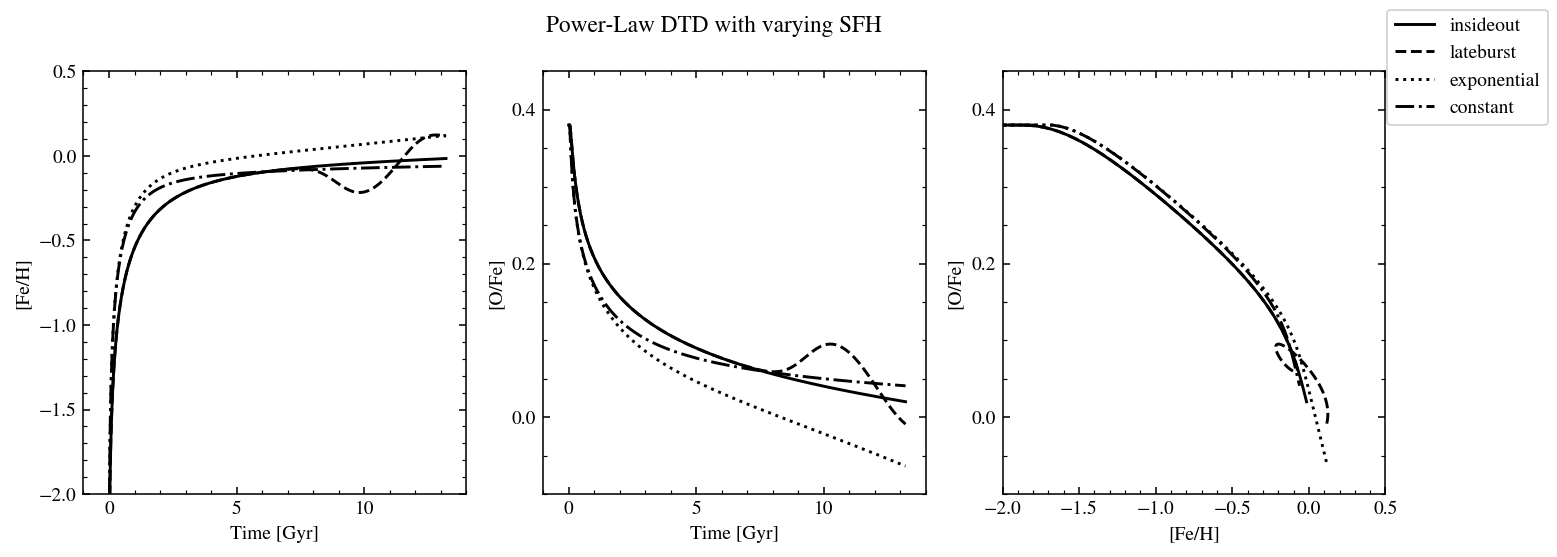

In [113]:
# Different SFHs with same DTD
fig, axs = tri_plot(olim=(-0.1, 0.45))
sfhs = ['insideout', 'lateburst', 'exponential', 'constant']
styles = ['-', '--', ':', '-.']
dtd = 'powerlaw'
c = 'k'
for sfh, ls in zip(sfhs, styles):
    history = vice.history(os.path.join('singlezone', sfh, dtd))
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=sfh)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
fig.suptitle('Power-Law DTD with varying SFH')
plt.show()

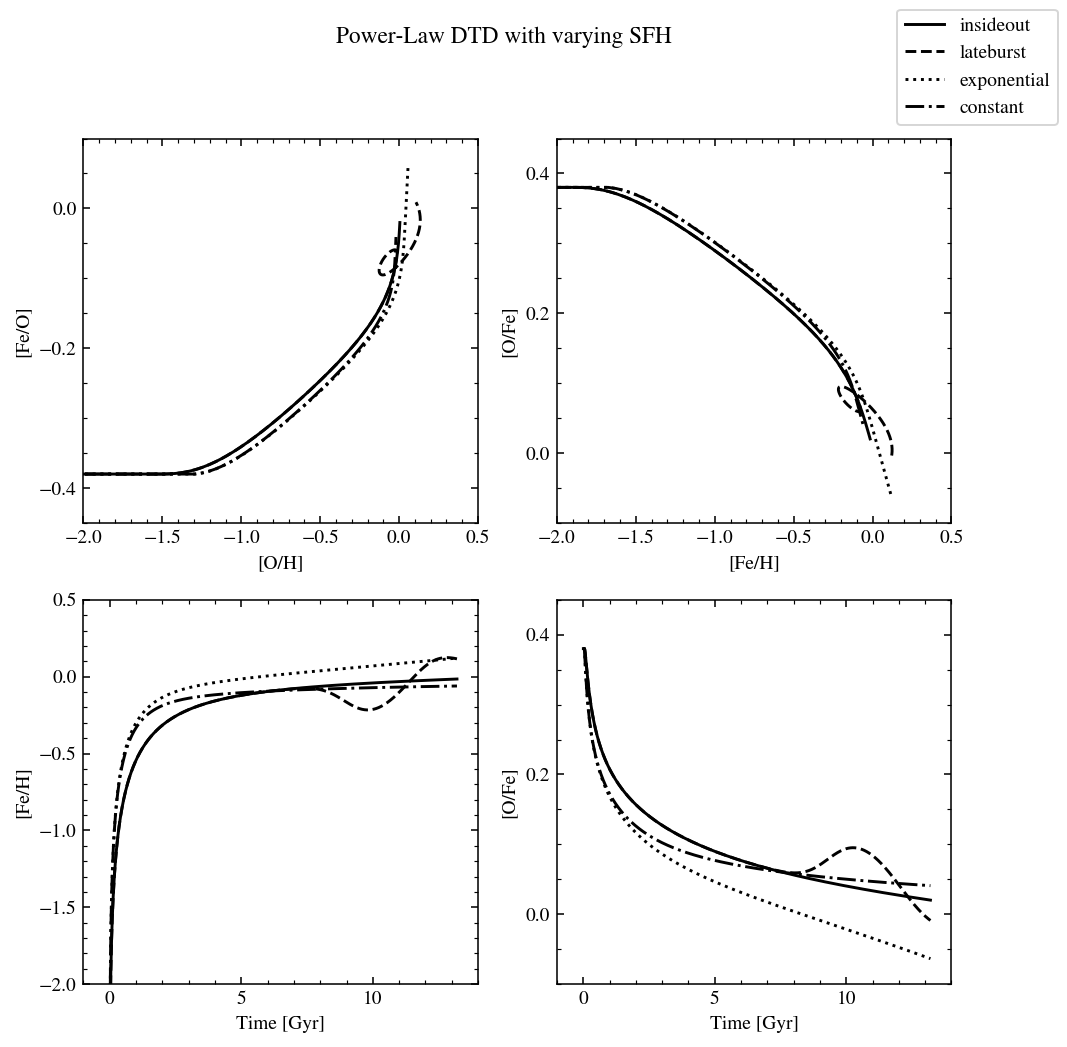

In [121]:
# Different SFHs with same DTD
fig, axs = quad_plot(ofelim=(-0.1, 0.45))
sfhs = ['insideout', 'lateburst', 'exponential', 'constant']
styles = ['-', '--', ':', '-.']
dtd = 'powerlaw'
c = 'k'
for sfh, ls in zip(sfhs, styles):
    history = vice.history(os.path.join('singlezone', sfh, dtd))
    axs[0,0].plot(history['[o/h]'], history['[fe/o]'], color=c, linestyle=ls, label=sfh)
    axs[0,1].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
    axs[1,0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls)
    axs[1,1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
fig.suptitle('Power-Law DTD with varying SFH')
plt.show()

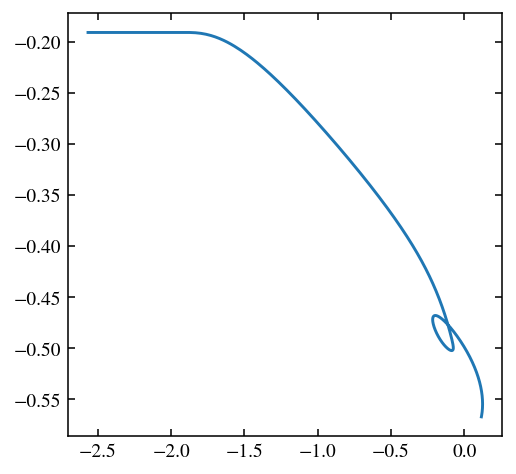

In [119]:
fig, ax = plt.subplots()
history = vice.history('singlezone/lateburst/powerlaw')
ax.plot(history['[fe/h]'], history['[mg/fe]'])
plt.show()

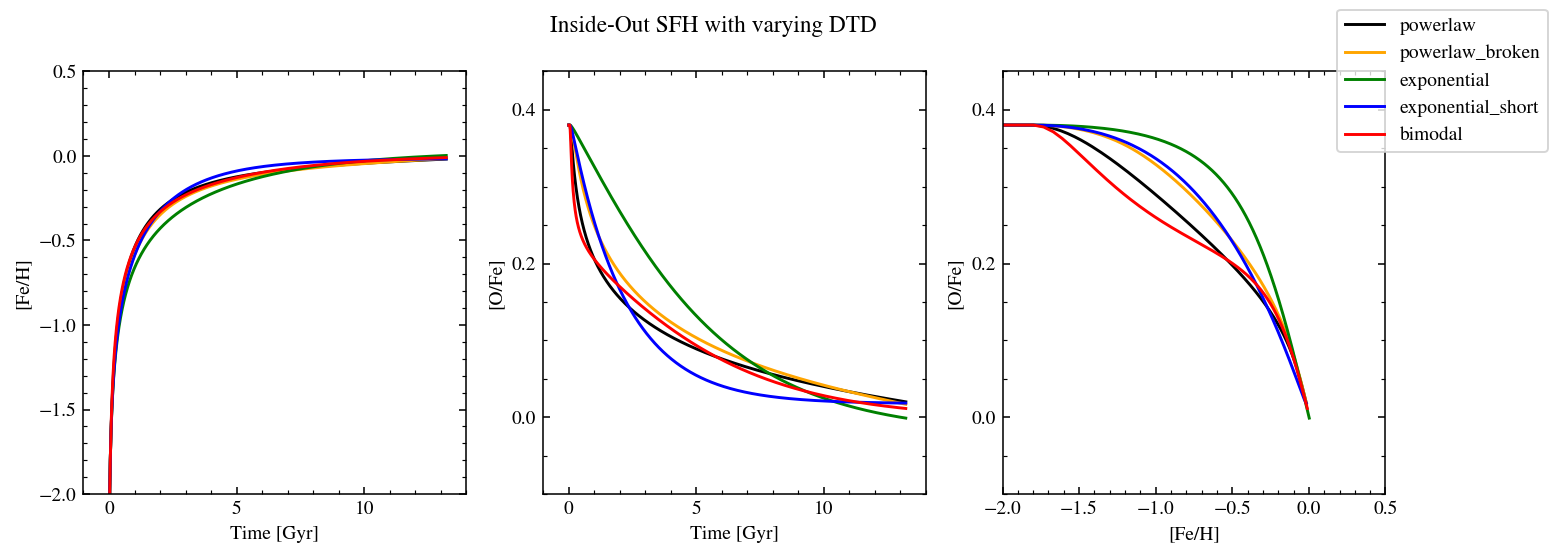

In [90]:
# Different DTDs with same SFH
fig, axs = tri_plot(olim=(-0.1, 0.45))
dtds = ['powerlaw', 'powerlaw_broken', 'exponential', 'exponential_short', 'bimodal']
sfh = 'insideout'
ls = '-'
for dtd in dtds:
    history = vice.history(str(os.path.join('singlezone', sfh, dtd)))
    c = COLORS[dtd]
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=dtd)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
fig.suptitle('Inside-Out SFH with varying DTD')
plt.show()

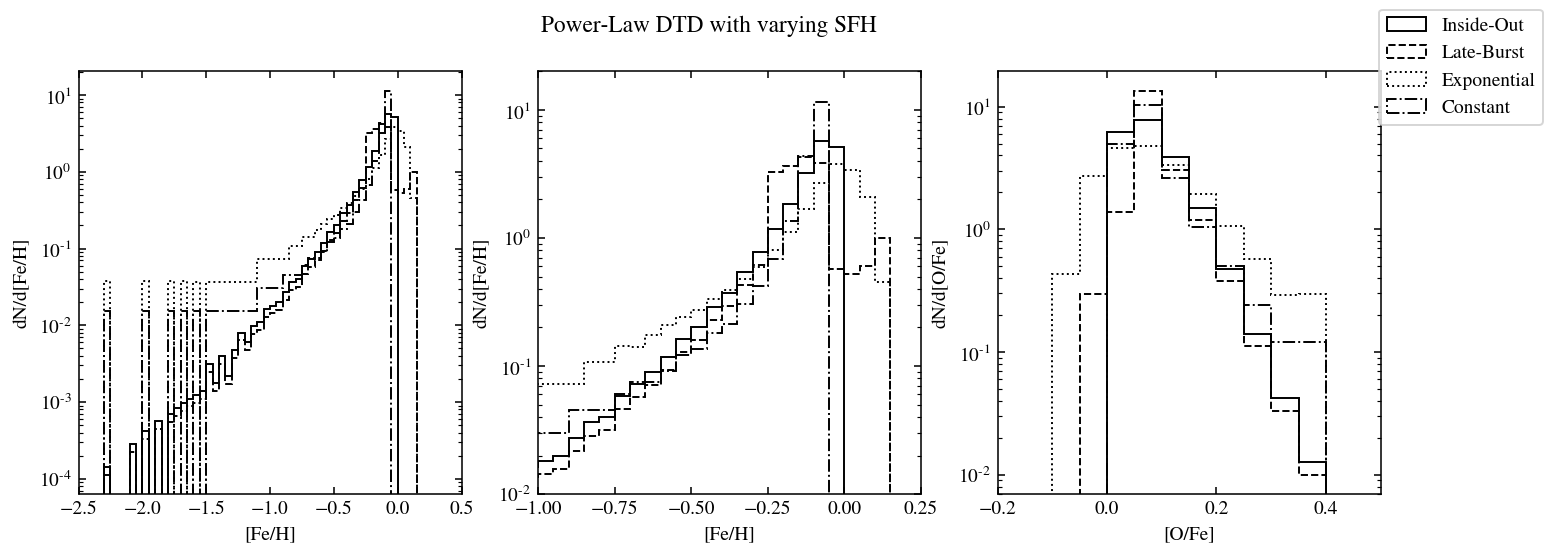

In [39]:
# MDFs
sfhs = ['insideout', 'lateburst', 'exponential', 'constant']
dtd = 'powerlaw'
runs = [os.path.join(sfh, dtd) for sfh in sfhs]
plot_mdf(runs, title='Power-Law DTD with varying SFH', 
         legend_labels=['Inside-Out', 'Late-Burst', 'Exponential', 'Constant'])

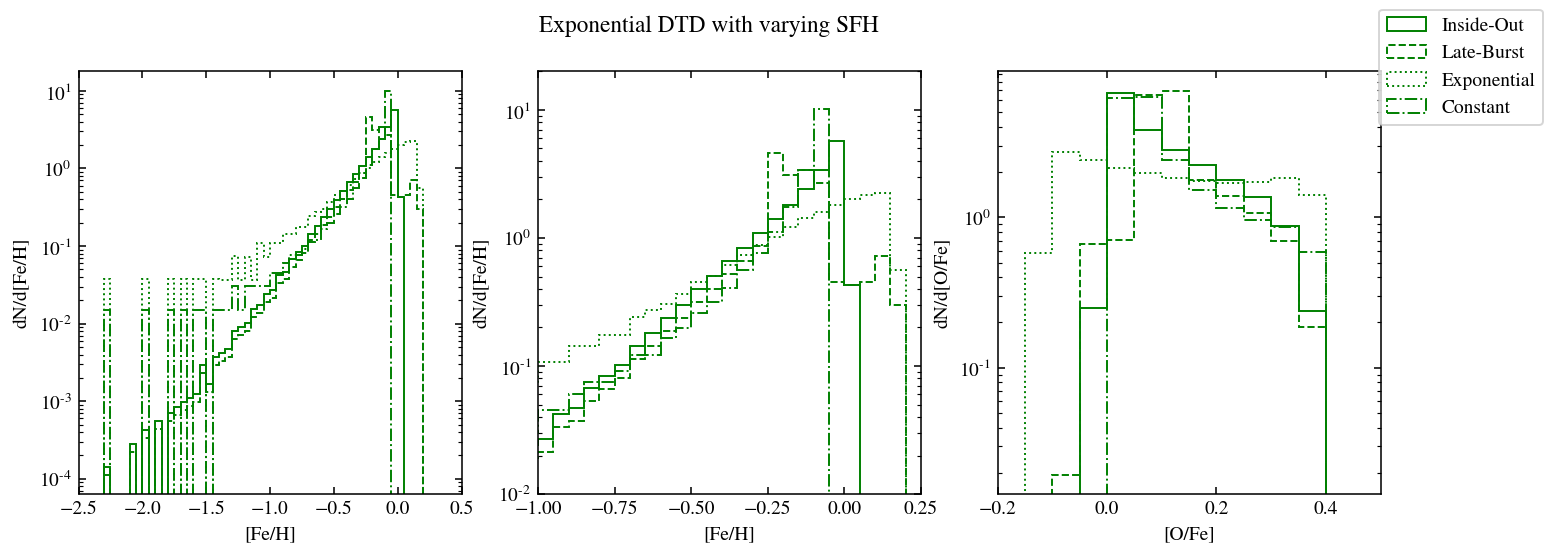

In [41]:
# MDFs
sfhs = ['insideout', 'lateburst', 'exponential', 'constant']
dtd = 'exponential'
runs = [os.path.join(sfh, dtd) for sfh in sfhs]
plot_mdf(runs, title='Exponential DTD with varying SFH', 
         legend_labels=['Inside-Out', 'Late-Burst', 'Exponential', 'Constant'])

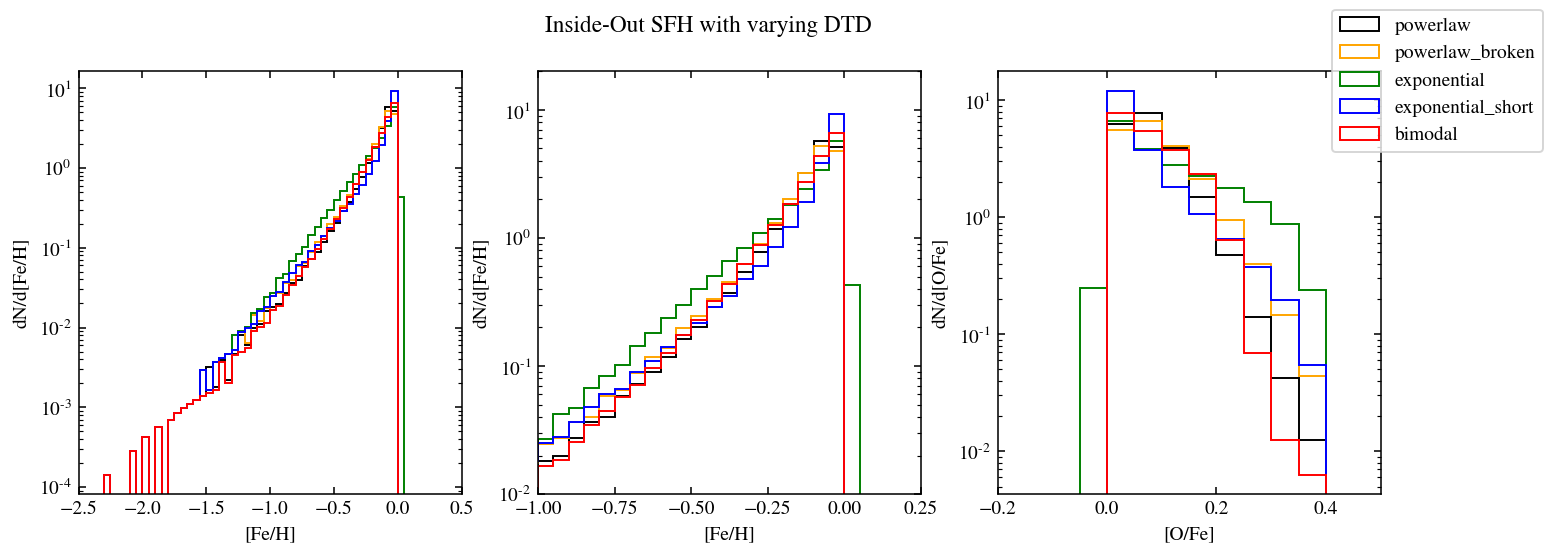

In [21]:
fig, axs = tri_mdf()
dtds = ['powerlaw', 'powerlaw_broken', 'exponential', 'exponential_short', 'bimodal']
sfh = 'insideout'
ls = '-'
for dtd in dtds:
    mdf = vice.mdf(str(os.path.join('singlezone', sfh, dtd)))
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    c = COLORS[dtd]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=dtd)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
fig.suptitle('Inside-Out SFH with varying DTD')
plt.show()

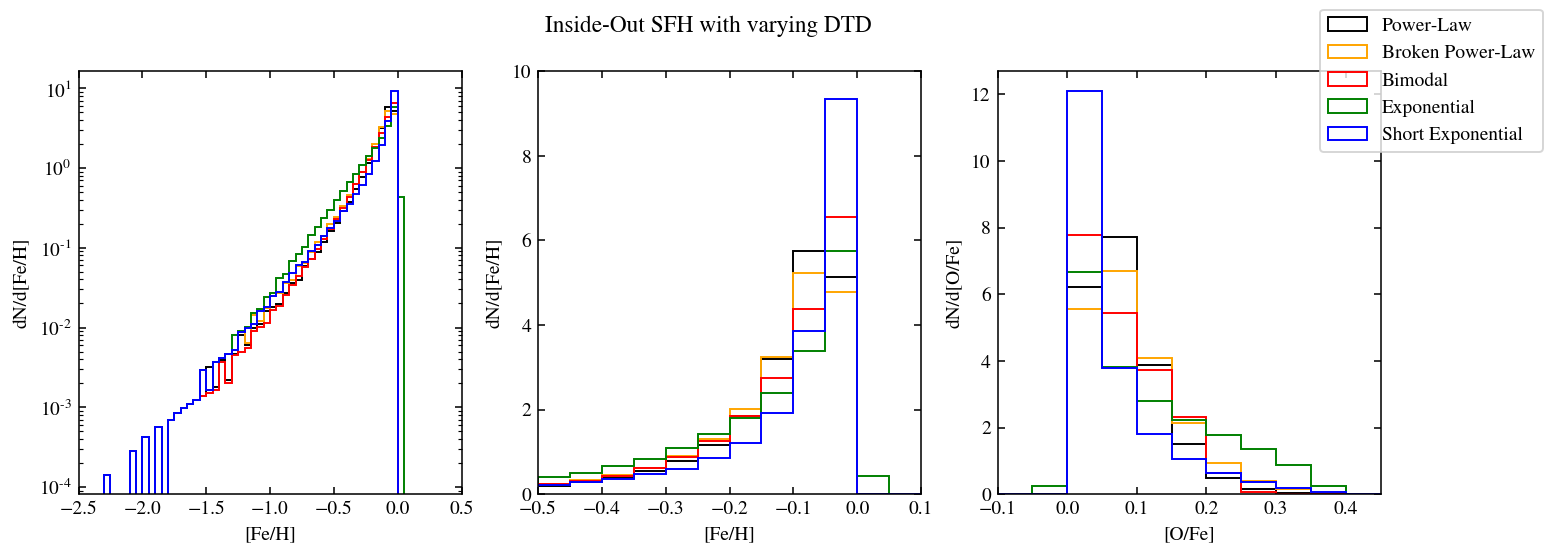

In [62]:
sfh = 'insideout'
dtds = ['powerlaw', 'powerlaw_broken', 'bimodal', 'exponential', 'exponential_short']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Inside-Out SFH with varying DTD', logy=False, ylim2=(0, 10), felim2=(-0.5, 0.1), olim=(-0.1, 0.45),
         legend_labels=['Power-Law', 'Broken Power-Law', 'Bimodal', 'Exponential', 'Short Exponential'])

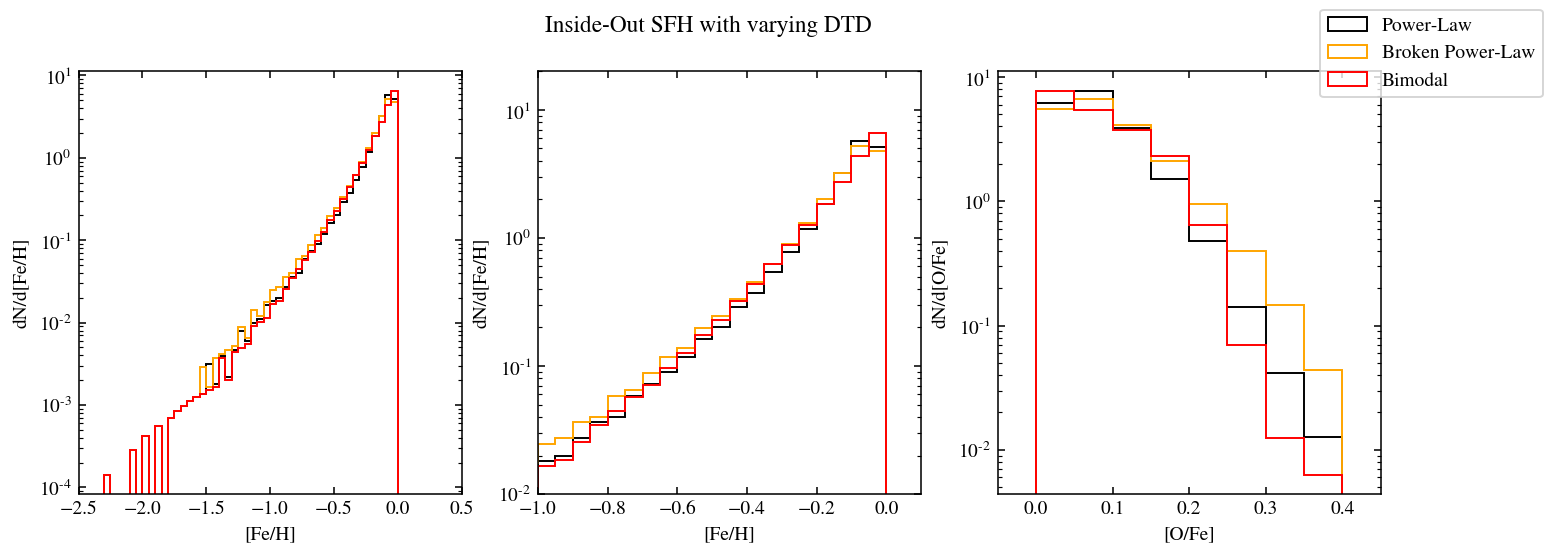

In [63]:
sfh = 'insideout'
dtds = ['powerlaw', 'powerlaw_broken', 'bimodal']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Inside-Out SFH with varying DTD', felim2=(-1, 0.1), olim=(-.05, .45),
         legend_labels=['Power-Law', 'Broken Power-Law', 'Bimodal'])

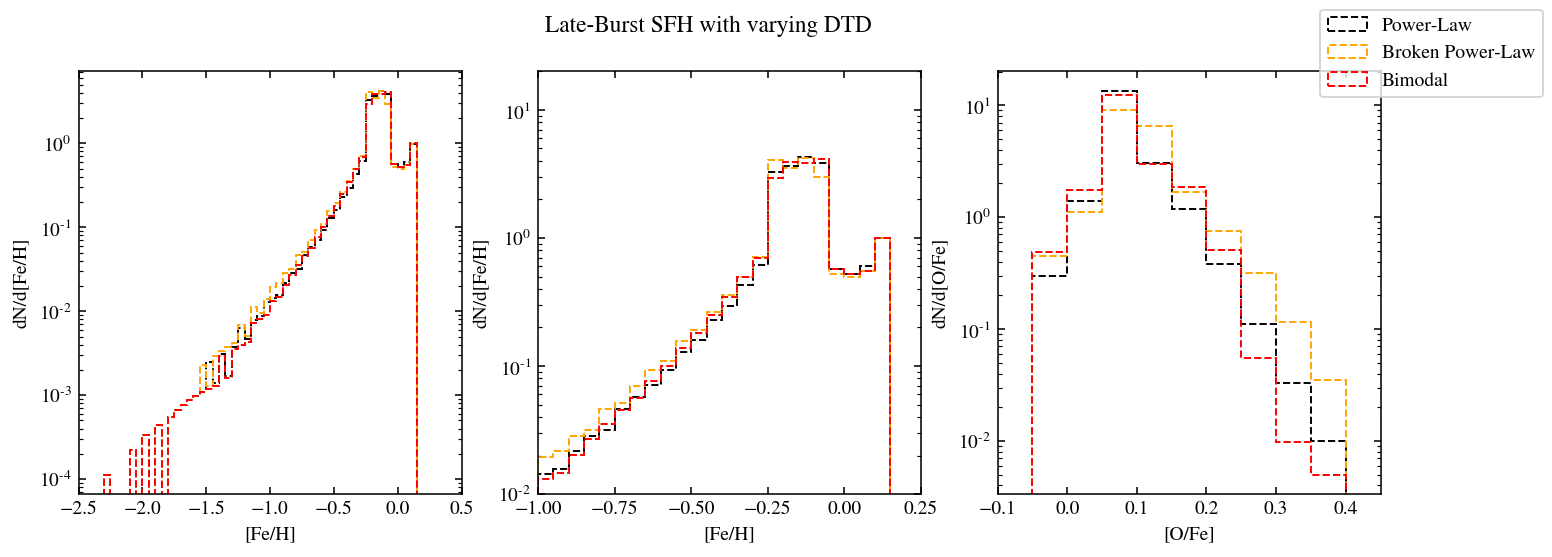

In [64]:
sfh = 'lateburst'
dtds = ['powerlaw', 'powerlaw_broken', 'bimodal']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Late-Burst SFH with varying DTD', olim=(-0.1, 0.45),
         legend_labels=['Power-Law', 'Broken Power-Law', 'Bimodal'])

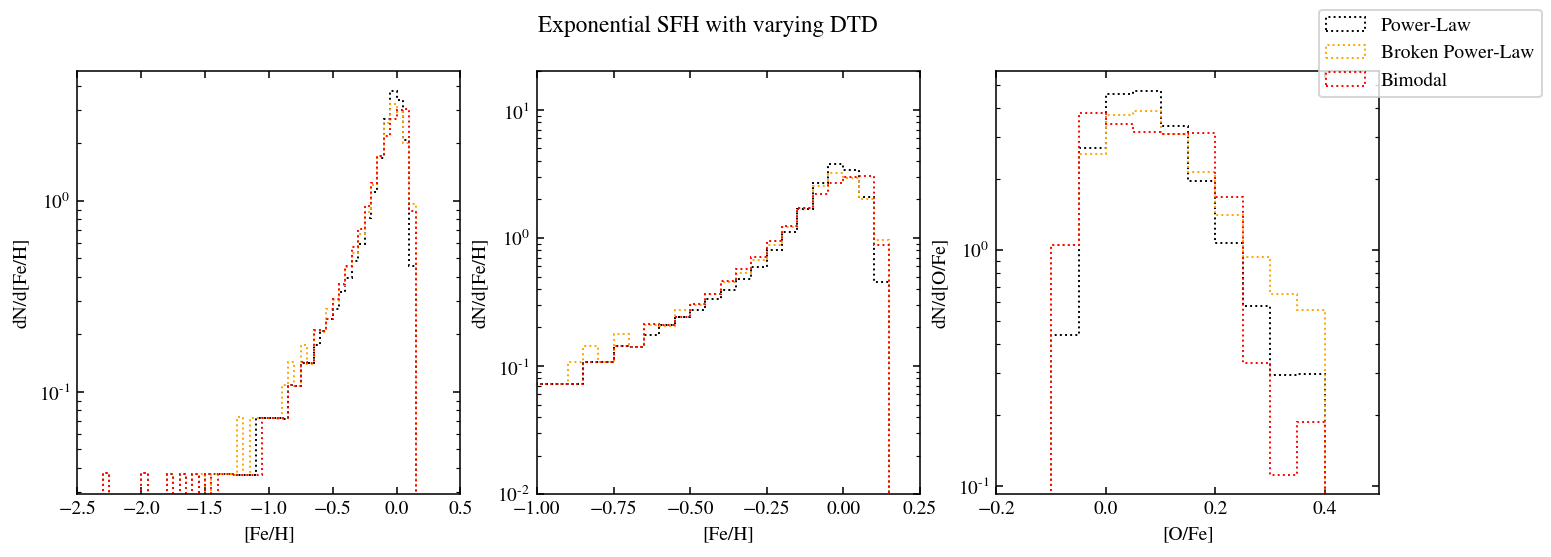

In [48]:
sfh = 'exponential'
dtds = ['powerlaw', 'powerlaw_broken', 'bimodal']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Exponential SFH with varying DTD', 
         legend_labels=['Power-Law', 'Broken Power-Law', 'Bimodal'])

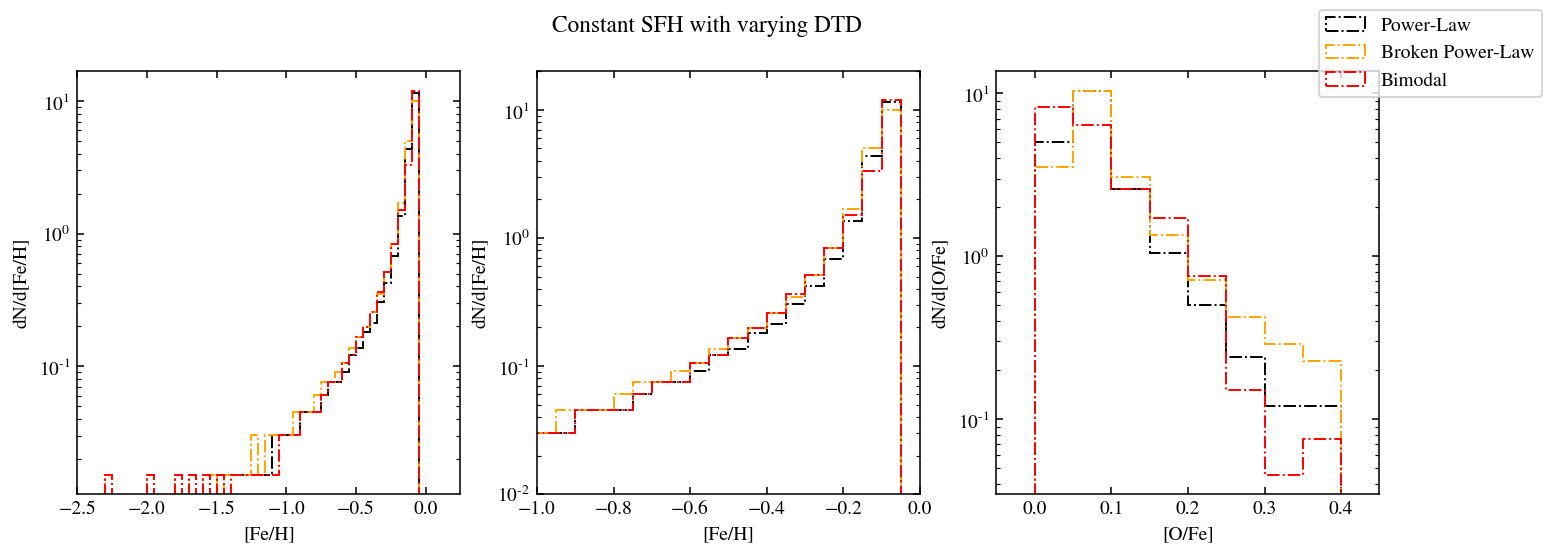

In [55]:
sfh = 'constant'
dtds = ['powerlaw', 'powerlaw_broken', 'bimodal']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Constant SFH with varying DTD', 
         legend_labels=['Power-Law', 'Broken Power-Law', 'Bimodal'],
         olim=(-.05, .45), felim1=(-2.5, 0.25), felim2=(-1,0))

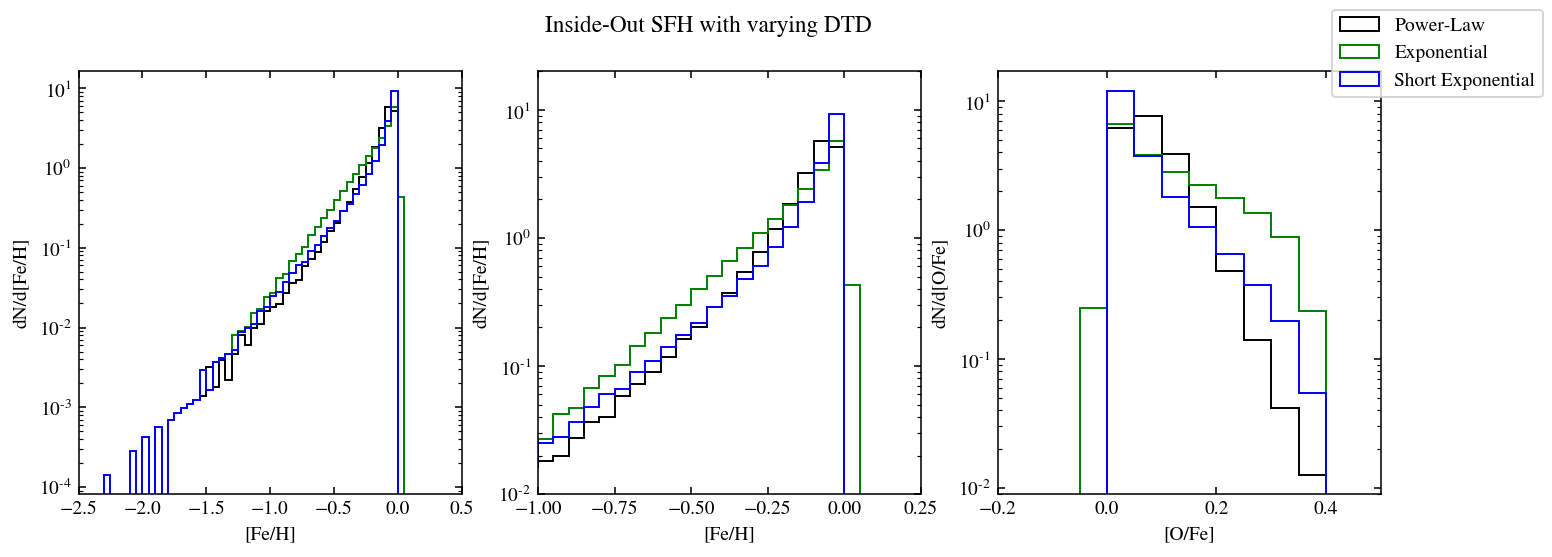

In [67]:
sfh = 'insideout'
dtds = ['powerlaw', 'exponential', 'exponential_short']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Inside-Out SFH with varying DTD',
         legend_labels=['Power-Law', 'Exponential', 'Short Exponential'])

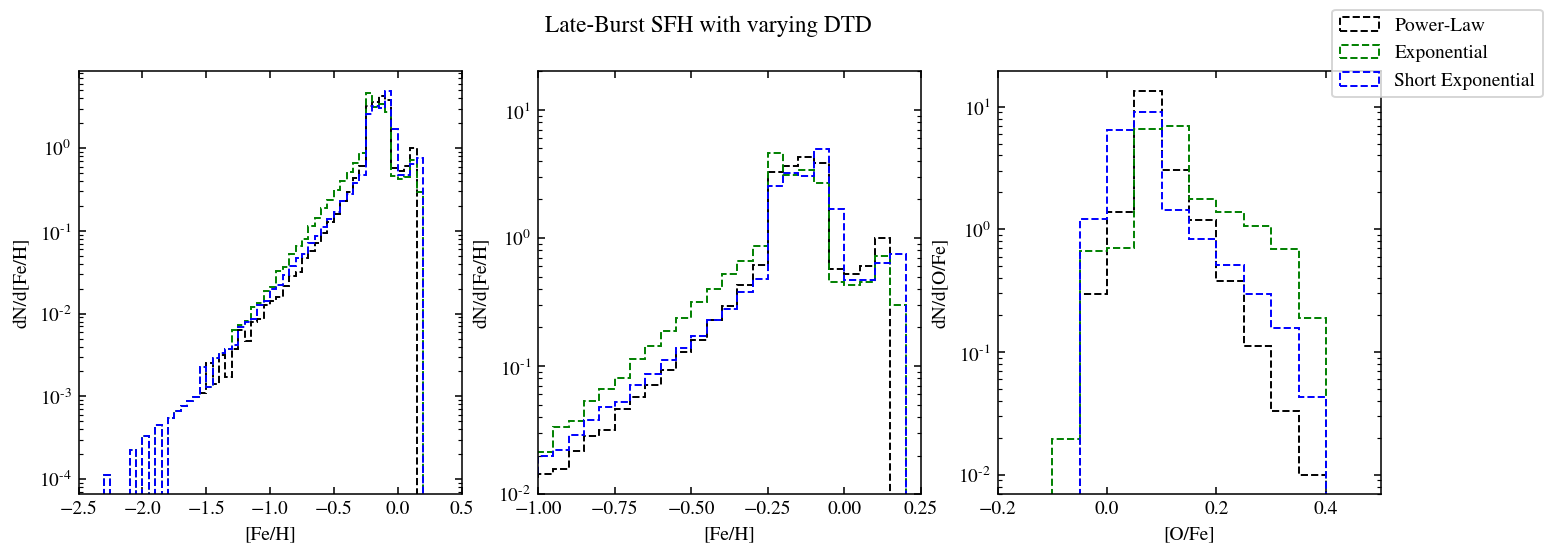

In [68]:
sfh = 'lateburst'
dtds = ['powerlaw', 'exponential', 'exponential_short']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Late-Burst SFH with varying DTD',
         legend_labels=['Power-Law', 'Exponential', 'Short Exponential'])

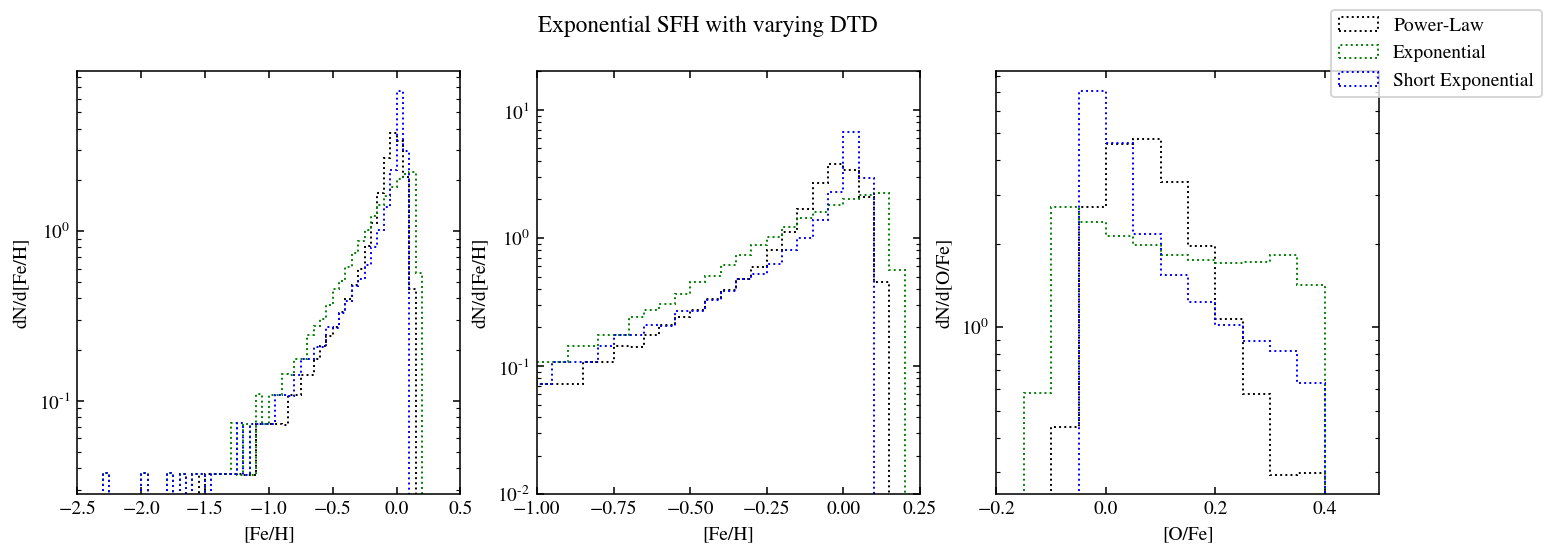

In [69]:
sfh = 'exponential'
dtds = ['powerlaw', 'exponential', 'exponential_short']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Exponential SFH with varying DTD',
         legend_labels=['Power-Law', 'Exponential', 'Short Exponential'])

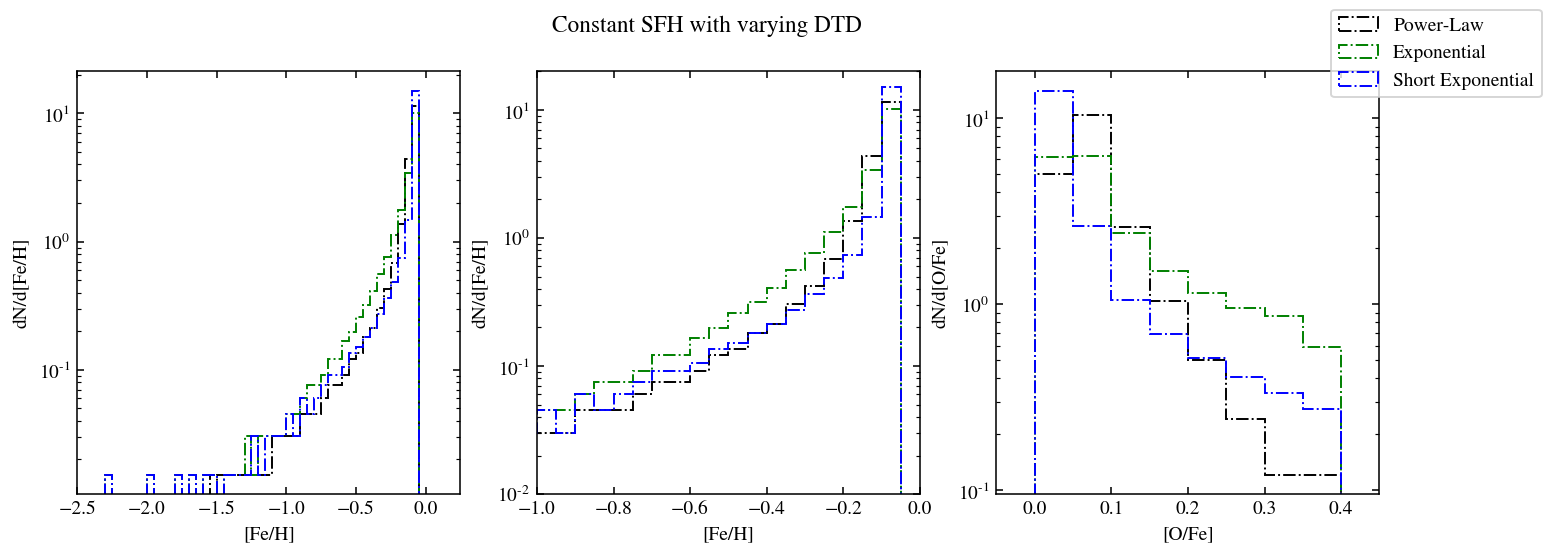

In [72]:
sfh = 'constant'
dtds = ['powerlaw', 'exponential', 'exponential_short']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Constant SFH with varying DTD', felim1=(-2.5, 0.25), felim2=(-1, 0), olim=(-0.05, 0.45),
         legend_labels=['Power-Law', 'Exponential', 'Short Exponential'])

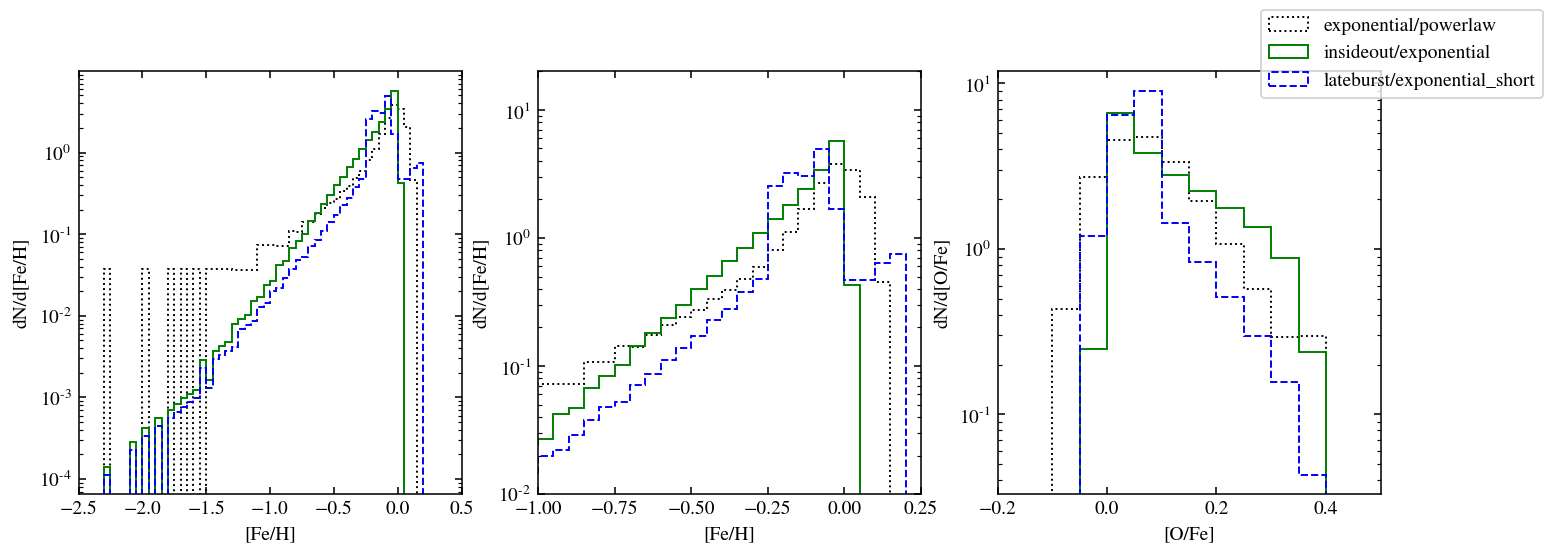

In [24]:
fig, axs = tri_mdf()
runs = ['exponential/powerlaw', 'insideout/exponential', 'lateburst/exponential_short']
for run in runs:
    mdf = vice.mdf('singlezone/' + run)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    sfh = run.split('/')[0]
    dtd = run.split('/')[1]
    c = COLORS[dtd]
    ls = LINESTYLES[sfh]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
plt.show()

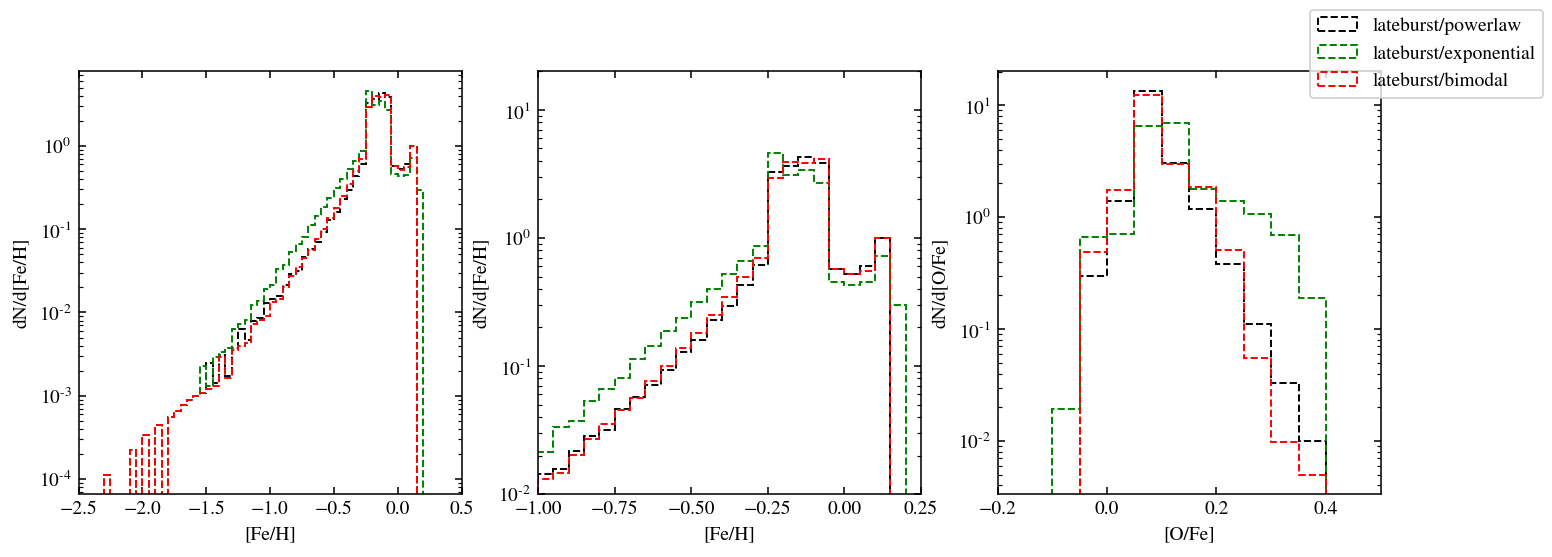

In [25]:
fig, axs = tri_mdf()
runs = ['lateburst/powerlaw', 'lateburst/exponential', 'lateburst/bimodal']
for run in runs:
    mdf = vice.mdf('singlezone/' + run)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    sfh = run.split('/')[0]
    dtd = run.split('/')[1]
    c = COLORS[dtd]
    ls = LINESTYLES[sfh]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
plt.show()

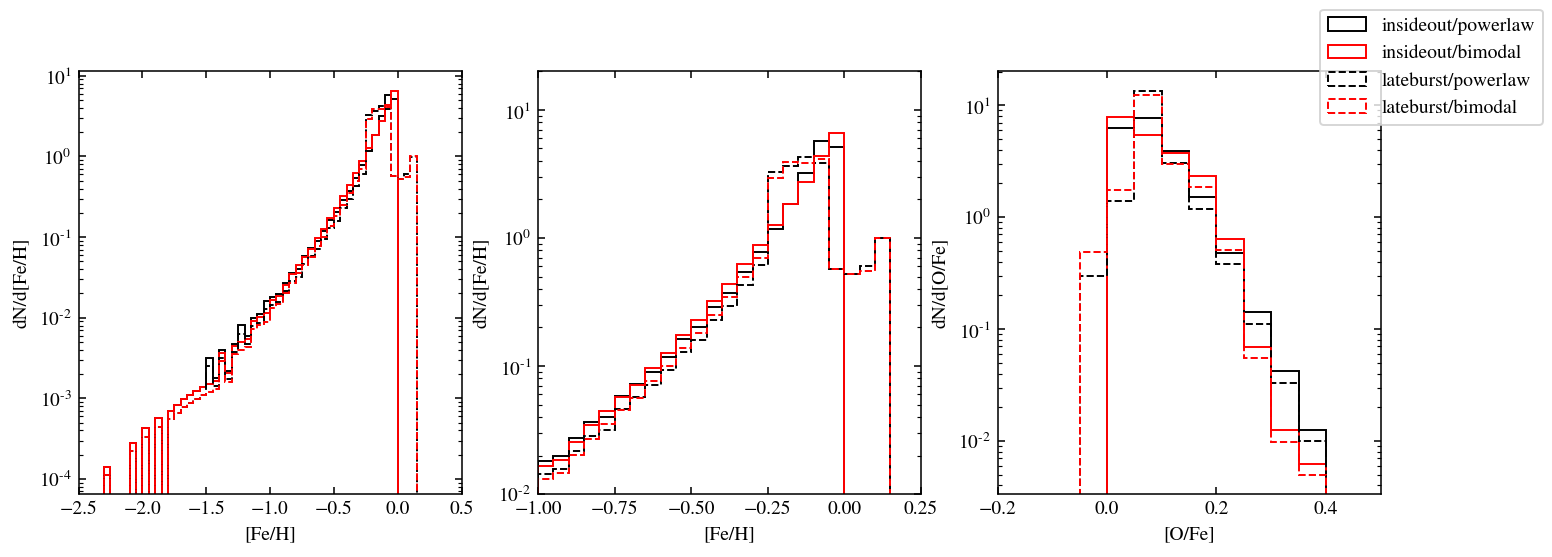

In [26]:
fig, axs = tri_mdf()
runs = ['insideout/powerlaw', 'insideout/bimodal', 'lateburst/powerlaw', 'lateburst/bimodal']
for run in runs:
    mdf = vice.mdf('singlezone/' + run)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    sfh = run.split('/')[0]
    dtd = run.split('/')[1]
    c = COLORS[dtd]
    ls = LINESTYLES[sfh]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
plt.show()

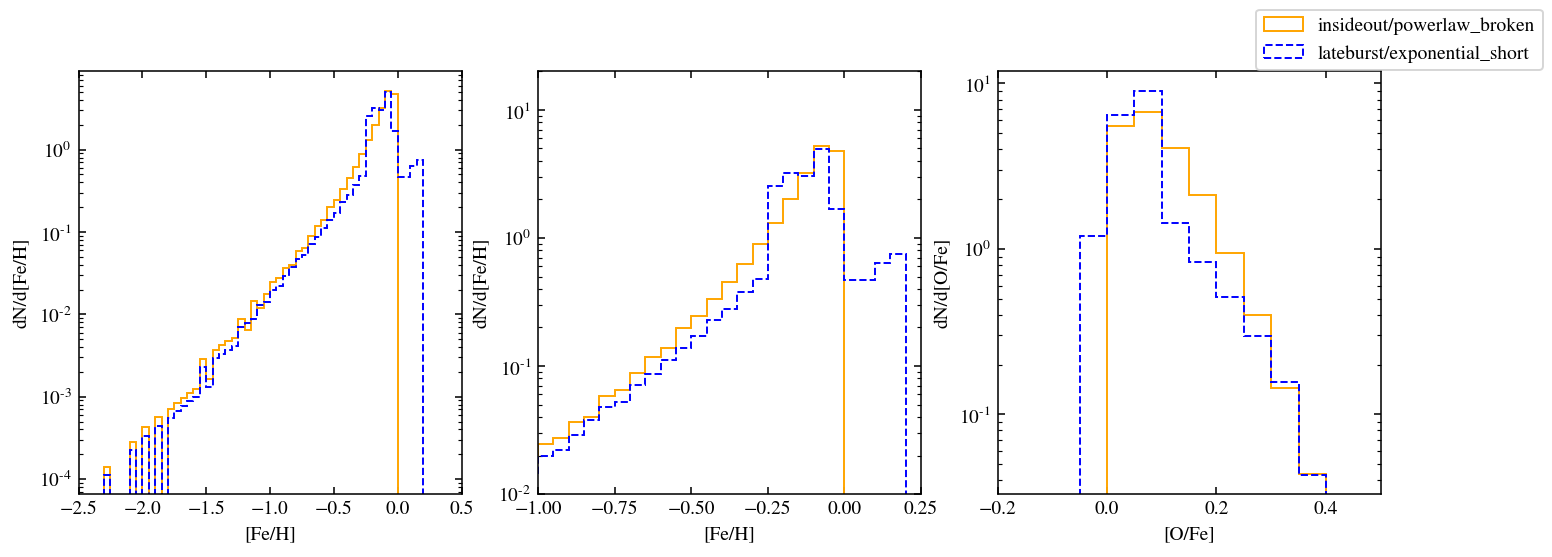

In [27]:
fig, axs = tri_mdf()
runs = ['insideout/powerlaw_broken', 'lateburst/exponential_short']
for run in runs:
    mdf = vice.mdf('singlezone/' + run)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    sfh = run.split('/')[0]
    dtd = run.split('/')[1]
    c = COLORS[dtd]
    ls = LINESTYLES[sfh]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
plt.show()

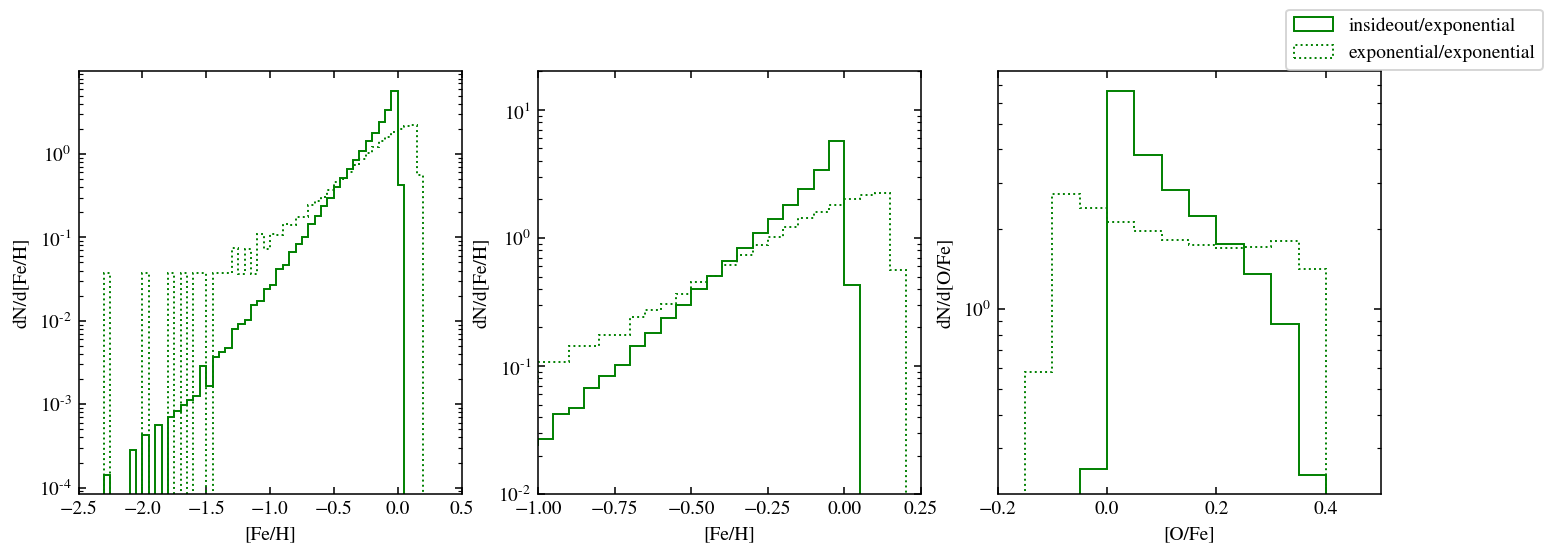

In [31]:
fig, axs = tri_mdf()
runs = ['insideout/exponential', 'exponential/exponential']
for run in runs:
    mdf = vice.mdf('singlezone/' + run)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    sfh = run.split('/')[0]
    dtd = run.split('/')[1]
    c = COLORS[dtd]
    ls = LINESTYLES[sfh]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
plt.show()

## Old stuff

In [49]:
# Power-law DTD with shorter 40 Myr delay time
sz = vice.singlezone(name='sz_short', elements=('o', 'fe'), RIa='plaw', delay=0.04)
sz.run(simtime)

In [73]:
# Exponential DTDs
# Medium timescale
sz = vice.singlezone(name='sz_exp', elements=('o', 'fe'), RIa='exp', tau_ia=1.5)
sz.run(simtime)
# Short timescale
sz = vice.singlezone(name='sz_sexp', elements=('o', 'fe'), RIa='exp', tau_ia=0.5)
sz.run(simtime)
# Long timescale
sz = vice.singlezone(name='sz_lexp', elements=('o', 'fe'), RIa='exp', tau_ia=5.5)
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_exp.vice
Overwite? (y | n)  y


In [8]:
# Wide gaussian DTD
def gauss(t, sigma=1, center=1):
    return np.exp(-(t-center)**2/(2*sigma**2))

sz = vice.singlezone(name='sz_wgauss', elements=('o', 'fe'), RIa=lambda t: gauss(t, sigma=2, center=3))
sz.run(simtime)

/home/lodubay/anaconda3/lib/python3.9/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: RIa
  warnings.warn("""\


In [38]:
# Narrow gaussian DTD
sz = vice.singlezone(name='sz_ngauss', elements=('o', 'fe'), RIa=lambda t: gauss(t, sigma=0.2, center=1))
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_ngauss.vice
Overwite? (y | n)  y


In [42]:
# Bimodal DTD
def bimodal(t, tau_ia=0.09):
    if t < tau_ia:
        return 10**(1.4 - 50*(np.log10(t*1e9) - 7.7)**2)
    else:
        return 10**(-0.8 - 0.9*(np.log10(t*1e9) - 8.7)**2)
    
sz = vice.singlezone(name='sz_bi', elements=('o', 'fe'), RIa=bimodal, delay=0.04)
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_bi.vice
Overwite? (y | n)  y


In [36]:
# Uniform DTD
def uniform(t, tmin=0, tmax=1):
    if t >= tmin and t < tmax:
        return 1
    else:
        return 0

sz = vice.singlezone(name='sz_uni', elements=('o', 'fe'), RIa=uniform)
sz.run(simtime)

Plot Fe vs time, alpha vs time, and alpha vs Fe.

In [70]:
sz = vice.singlezone(name='sz_long_sfe', elements=('o', 'fe'), tau_star=5)
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_long_sfe.vice
Overwite? (y | n)  y


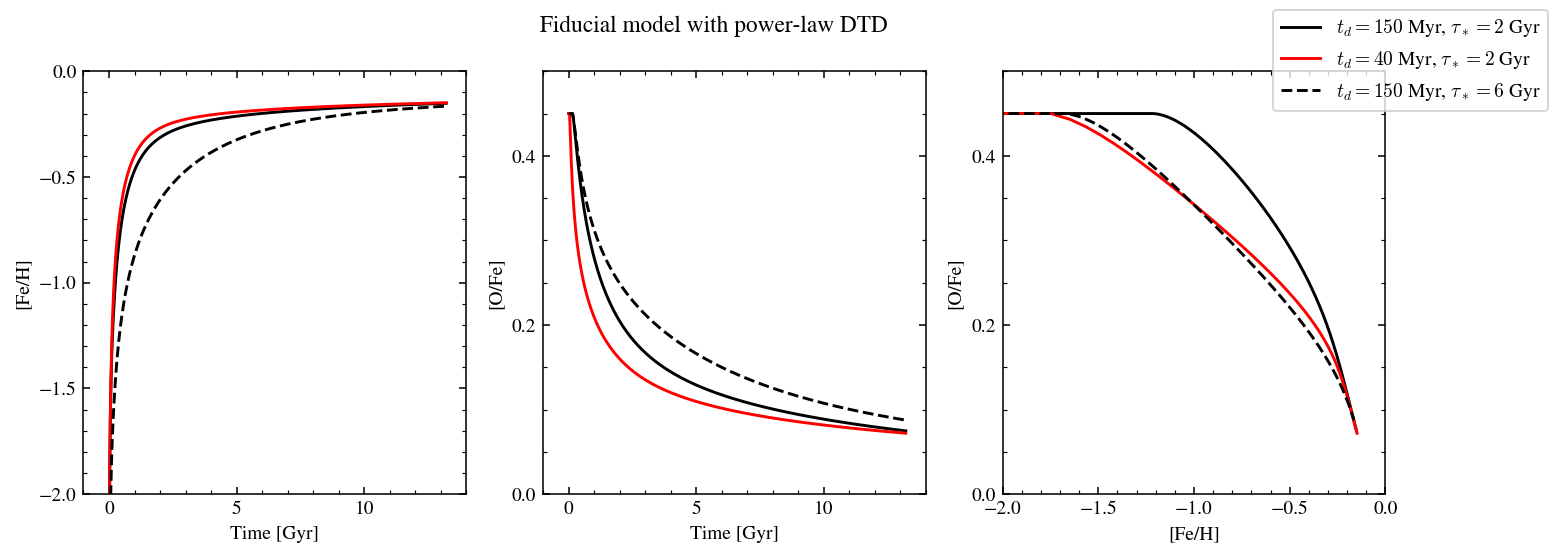

In [6]:
# Altering minimum delay time vs star formation efficiency timescale
fig, axs = tri_plot(felim=(-2, 0), olim=(0, 0.5))
                                         
# 150 Myr delay
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.15, tau_star=2)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=150$ Myr, $\tau_*=2$ Gyr'
style = 'k'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# 40 Myr delay
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.04, tau_star=2)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=40$ Myr, $\tau_*=2$ Gyr'
style = 'r'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# 150 Myr delay with 5 Gyr SFE timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.15, tau_star=6)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=150$ Myr, $\tau_*=6$ Gyr'
style = 'k--'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

fig.suptitle('Fiducial model with power-law DTD')
fig.legend()
plt.show()

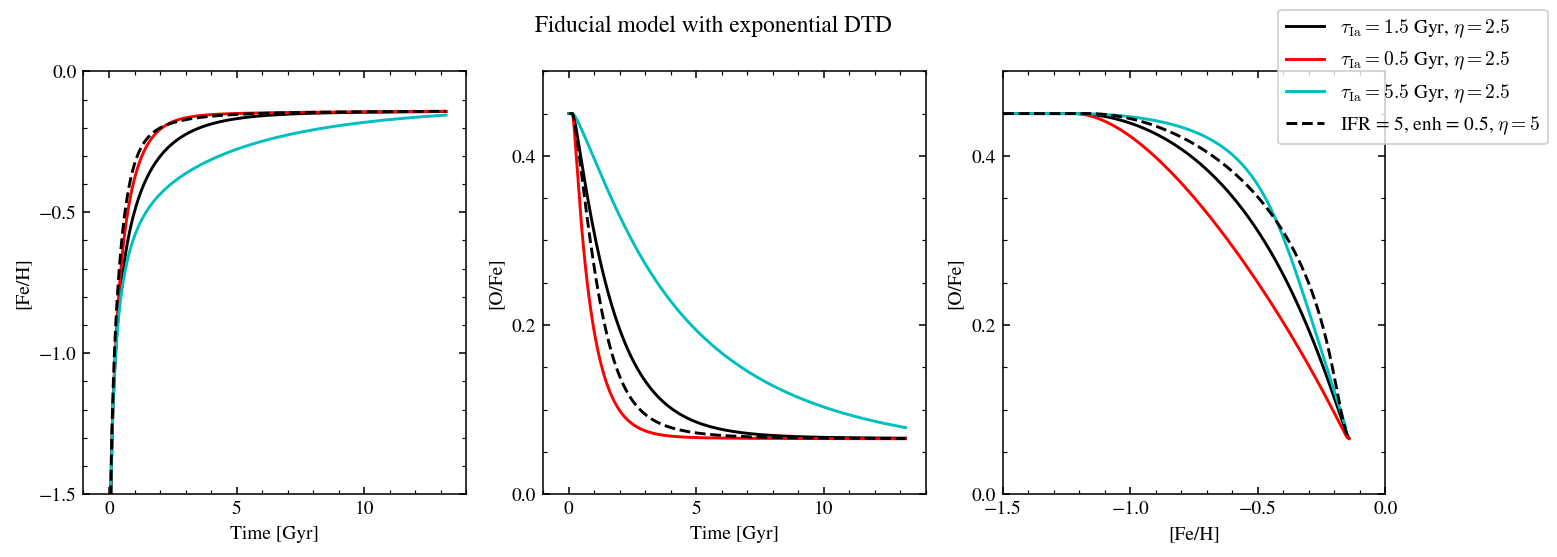

In [146]:
# Altering exponential Ia timescale vs star formation efficiency timescale
fig, axs = tri_plot(felim=(-1.5, 0), olim=(0, 0.5))
                                         
# Fiducial Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=1.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=1.5$ Gyr, $\eta=2.5$'
style = 'k'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Shorter Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=0.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=0.5$ Gyr, $\eta=2.5$'
style = 'r'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Longer Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=5.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=5.5$ Gyr, $\eta=2.5$'
style = 'c'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Other parameter changes
# need to set Mg0
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=1.5, mode='ifr', func=lambda t: 5, enhancement=0.5, eta=5)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = 'IFR = 5, enh = 0.5, $\eta=5$'
style = 'k--'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

fig.suptitle('Fiducial model with exponential DTD')
fig.legend()
plt.show()